In [2]:
import utils
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

# RQ1-A.TrickyBugs (C++)


First we handle the data about test inputs. The oracles and validities of test inputs are only related to the coding task and are independent of the PUTs.

A.1.1. Load the reference dataframes.
- `ref_direct`: The outputs of canonical solutions on DPP direct-generated inputs.
- `ref_generator`: The outputs of canonical solutions on TC generator-generated inputs.
- `ref_chat`: The outputs of canonical solutions on inputs extracted from LLM-generated test cases.


A.1.2. Load the input validity dataframes.
- `input_valid_direct`: The validity of positive test inputs from DPP direct-generated inputs.
- `input_valid_generator`: The validity of positive test inputs from TC generator-generated inputs.
- `input_valid_chat`: The validity of positive test inputs extracted from LLM-generated test cases.


In [3]:
ref_direct=pd.read_pickle("../Data/ref_direct.pkl")
ref_generator=pd.read_pickle("../Data/ref_generator.pkl")
ref_chat=pd.read_pickle("../Data/ref_chat.pkl")
input_valid_direct=pd.read_pickle("../Data/input_valid_direct.pkl")
input_valid_generator=pd.read_pickle("../Data/input_valid_generator.pkl")
input_valid_chat=pd.read_pickle("../Data/input_valid_chat.pkl")

A.1.3. Then Load the result dataframes of differential tetsing.
- `dpp_res`: The outputs of PUTs and DPP's all programs variants on all DPP's direct-genereted test inputs.
- `tc_res`: The outputs of PUTs and TC's all programs variants on all TC's generator-genereted test inputs.
- `chat_res`: The outputs of PUTs on all inputs extracted from LLM generated test cases.

In [4]:
dpp_res=pd.read_pickle("../Data/dpp_res.pkl")
tc_res=pd.read_pickle("../Data/tc_res.pkl")
chat_res=pd.read_pickle("../Data/chat_res.pkl")

A.2. Compute the result of `DPP`. 

A.2.1. Post-processing the `dpp_res`, and compuete the trigger dataframe.
- `dpp_trigger`: This is an important middle data. It records all experiment results where the output of some program variants are inconsistent with that of PUT. This trigger dataframe is very useful for computing the number of TP and FP. 

The computation is very time-consuming, and an alternative choice is to load the `dpp_trigger` directly.

In [5]:
# df_dpp=dpp_res.merge(input_valid_direct,on=['pid','input_name'],how='left')
# df_dpp['input_valid']=pd.to_numeric(df_dpp['input_valid'], errors='coerce').fillna(-1).astype(int)
# df_dpp=(df_dpp
# [~(    
#     (df_dpp['out']=='TIME_OUT' )|
#     (df_dpp['out']=='RUN_ERROR' )|
#     (df_dpp['out']=='')
# )
# ])
# df_dpp=pd.merge(df_dpp,ref_direct, on=['pid', 'input_name'], suffixes=('', '_ref'),how='left')
# df_dpp['out_correct']= (df_dpp['out']==df_dpp['ref_out'])
# dpp_trigger=utils.get_trigger_df(df_dpp,'cpp','dfp') 
# dpp_trigger['len_sol_names']=dpp_trigger['sol_names'].apply(lambda x:len(x))
# dpp_trigger['final_valid']= ( (dpp_trigger['input_valid'] == 1) & dpp_trigger['input_valid_byref'] & dpp_trigger['out_correct'] )
# dpp_trigger['total_sols_num']=dpp_trigger['pid'].apply(lambda x:len(df_dpp[df_dpp['pid']==x].drop_duplicates(subset=['sol_name']))-1)
# for i in range(10):
#     column_name=f"num{i}"
#     dpp_trigger[column_name] = dpp_trigger['sol_names'].apply(lambda x: 1 if column_name in [sol.split('_')[1] for sol in x] else 0)



#  **WARNING**: The codes above in this block are time consuming. An alternative choice is to load the result directly
dpp_trigger=pd.read_pickle("../Data/dpp_trigger.pkl")



A.2.2. Compute the average number of TP and FP with different $k$ (the number of generated program variants) of different PUTs. 

The results for each PUT are an average summary of repeated experiments across different rounds.

In [6]:
dpp_results={}
for i in range(2,11):
    dpp_results[i]=utils.compute_res_df(dpp_trigger,i,'dfp')

A.2.3. Print the results. 
- The final recall is based on average TP numbers of each PUT.
- The final precision is the average precision of each PUT.
- The final F1 score is computed based on final recall and final precision.

In [7]:
print("DPP all res:")
len_PUT=251
for i in range(2,11):
    print(f"k={i}:   ",end="")
    recall=dpp_results[i]['TP_rate'].sum()/len_PUT
    precision=dpp_results[i]['precision'].mean()
    F1_score=2*precision*recall/(precision+recall)
    print(recall,precision,F1_score)

DPP all res:
k=2:   0.20956623711371966 0.2636987240299441 0.23353661844350743
k=3:   0.20396645390996487 0.29021802532171725 0.23956536060239783
k=4:   0.19460538744282999 0.32221122325619306 0.24265489398798137
k=5:   0.1852205203142131 0.3642672875412245 0.24557333417517072
k=6:   0.17680501283089603 0.41599864490486327 0.24814504698223278
k=7:   0.16945312103933516 0.4669620060512271 0.24866841143111093
k=8:   0.1630807527206393 0.5309215052683013 0.24951814700323122
k=9:   0.1577982893399422 0.5549010872975481 0.24572055258851463
k=10:   0.1550393198448038 0.6080448325163399 0.2470785351177508


A.3.Compute the result of `TC`. 

A.3.1. Similarly to step 4.1, post-processing the `tc_res`, and compuete the `tc_trigger`. And an alternative choice is to load the `tc_trigger` directly.

In [8]:
# df_tc=pd.merge(tc_res,ref_generator, on=['pid', 'input_name'], suffixes=('', '_ref'),how='left')
# df_tc['out_correct']= (df_tc['out']==df_tc['ref_out'])
# df_tc=(df_tc
# [~(    
#     (df_tc['out']=='TIME_OUT' )|
#     (df_tc['out']=='RUN_ERROR' )|
#     (df_tc['out']=='')
# )
# ])
# df_tc['input_group']=df_tc['input_name'].apply(lambda x: x.split('_')[0]).astype(int)
# df_tc=pd.merge(df_tc,input_valid_generator,on=['pid','input_group'],how='left')
# df_tc['input_valid']=df_tc['input_valid'].fillna(-1)
# df_tc['input_valid']=df_tc['input_valid'].astype(int)

# tc_trigger=utils.get_trigger_df(df_tc,'cpp','tc')
# tc_trigger['len_sol_names']=tc_trigger['sol_names'].apply(lambda x:len(x))
# tc_trigger['final_valid']= ( (tc_trigger['input_valid'] != 0) & tc_trigger['input_valid_byref'] & tc_trigger['out_correct'] )
# tc_trigger['total_sols_num']=tc_trigger['pid'].apply(lambda x:len(df_tc[df_tc['pid']==x].drop_duplicates(subset=['sol_name']))-1)
# for i in range(10):
#     column_name=f"num{i}"
#     tc_trigger[column_name] = tc_trigger['sol_names'].apply(lambda x: 1 if column_name in [sol.split('_')[1] for sol in x] else 0)



#  **WARNING**: The codes above in this block are time consuming. An alternative choice is to load the result directly
tc_trigger=pd.read_pickle("../Data/tc_trigger.pkl")

A.3.2. Similarly to step 4.2. Compute the average number of TP and FP with different $k$ of different PUTs.

In [9]:
tc_results={}
for i in range(2,11):
    tc_results[i]=utils.compute_res_df(tc_trigger,i,'tc')

A.3.3. Print the results. 
- The final recall is based on average TP numbers of each PUT.
- The final precision is the average precision of each PUT.
- The final F1 score is computed based on final recall and final precision.

In [10]:
print("TC all res:")
for i in range(2,11):
    print(f"k={i}:   ",end="")
    recall=tc_results[i]['TP_rate'].sum()/len_PUT
    precision=tc_results[i]['precision'].mean()
    F1_score=2*precision*recall/(precision+recall)
    print(recall,precision,F1_score)

TC all res:
k=2:   0.25064899043199457 0.6991469199396292 0.3690065786405434
k=3:   0.26746132155212354 0.698565502120137 0.386820009153623
k=4:   0.27743369969517 0.6969281770001491 0.3968779304517519
k=5:   0.2831001070894958 0.6956268470073805 0.40242487255056225
k=6:   0.2865356201045365 0.694509997111865 0.4056933728645398
k=7:   0.289387750720712 0.6939485627652917 0.4084466543955757
k=8:   0.29189056555686216 0.6934809094265741 0.410851217017039
k=9:   0.2930941143958002 0.6940247425787345 0.41213794237168544
k=10:   0.2937987576038061 0.6956932845146728 0.4131287852019906


A.4. Compute the reslut of `CHAT`.

A generated test case could be a TP, FP, or negative. CHAT generates 100 test cases for each PUT, and the values for TP and FP for each PUT are obtained by averaging the results of all test cases.

In [20]:
df_chat=chat_res.copy()
df_chat['input_name']=chat_res['input_name'].apply(lambda x:'.'.join( ("_".join(x.split('_')[1:]).split('.')[:-1] )))
df_chat=df_chat.merge(ref_chat,on=['pid','input_name'],how='left')
df_chat['triger']= (df_chat['out']!=df_chat['chat_out'])
df_chat=df_chat.merge(input_valid_chat,on=['pid','input_name'],how='left')
df_chat['input_valid']=df_chat['input_valid'].fillna(-1)
df_chat['input_valid']=df_chat['input_valid'].astype(int)
df_chat['final_valid']= ( (df_chat['input_valid'] == 1) & df_chat['input_valid_byref'] & df_chat['out_correct'] )

chat_results=pd.DataFrame(columns=['pid','total','TP','FP'])
for pid in df_chat['pid'].unique():
    df_tmp=df_chat[df_chat['pid']==pid]
    df_tmp=df_tmp.drop_duplicates(subset=['input_name'])
    total=len(df_tmp)
    df_tmp=df_tmp[df_tmp['triger']==True]
    TP=len(df_tmp[df_tmp['final_valid']==True])
    FP=len(df_tmp[df_tmp['final_valid']==False])
    chat_results.loc[len(chat_results)]=[pid,total,TP,FP]
chat_results['TP_rate']=chat_results['TP']/chat_results['total']
chat_results['FP_rate']=chat_results['FP']/chat_results['total']
chat_results['precision']=chat_results['TP']/(chat_results['TP']+chat_results['FP'])

print("CHAT res:")
recall=chat_results['TP_rate'].sum()/len_PUT
precision=chat_results['precision'].mean()
F1_score=2*precision*recall/(precision+recall)
print(recall,precision,F1_score)

CHAT res:
0.03780686934406874 0.06312328556214565 0.047290005886425956


A.5. Compute the reslut of `ARR`.

Please refer to Section 4.4 of paper for details of this baseline.

In [17]:
pid_set=set(list(df_chat['pid']))
APR_check=pd.read_pickle("../Data/tc_submit_base_and_extra.pkl")
repair_check_group_by_pid=APR_check.groupby('pid')
res_df=pd.DataFrame(columns=['pid','total','TP','FP'])
for pid,group in repair_check_group_by_pid:
    if pid not in pid_set:
        continue
    repair_pid=APR_check[APR_check['pid']==pid]
    total=len(repair_pid)
    repair_pid=repair_pid[repair_pid['base']=='AC']
    if len(repair_pid)<1:
        continue
    res_df.loc[len(res_df)]=[pid,total,len(repair_pid[repair_pid['extra']=='AC']),len(repair_pid[repair_pid['extra']!='AC'])]
res_df['TP_rate']=res_df['TP']/res_df['total']
res_df['FP_rate']=res_df['FP']/res_df['total']
res_df['precision']=res_df['TP']/(res_df['TP']+res_df['FP'])
recall=res_df['TP_rate'].sum()/len_PUT
precision=res_df['precision'].mean()
F1_score=2*precision*recall/(precision+recall)
print(recall,precision,F1_score)

0.16460823373173972 0.34580896686159845 0.22304500388119708


# RQ1-B. TrickyBugs (Python)
B.1. Load the result dataframes of differential tetsing.
- `dpp_res_py`: The outputs of PUTs and DPP's all programs variants on all DPP's direct-genereted test inputs.
- `tc_res_py`: The outputs of PUTs and TC's all programs variants on all TC's generator-genereted test inputs.
- `chat_res_py`: The outputs of PUTs on all inputs extracted from LLM generated test cases.

In [12]:
dpp_res_py=pd.read_pickle("../Data/dpp_res_py.pkl")
tc_res_py=pd.read_pickle("../Data/tc_res_py.pkl")
chat_res_py=pd.read_pickle("../Data/chat_res_py.pkl")

B.2. Compute the result of `DPP`

B.2.1. Compute `dpp_trigger_py` or load it.

In [13]:
# df_dpp_py=dpp_res_py.merge(input_valid_direct,on=['pid','input_name'],how='left')
# df_dpp_py['input_valid']=pd.to_numeric(df_dpp_py['input_valid'], errors='coerce').fillna(-1).astype(int)
# df_dpp_py=(df_dpp_py
# [~(    
#     (df_dpp_py['out']=='TIME_OUT' )|
#     (df_dpp_py['out']=='RUN_ERROR' )|
#     (df_dpp_py['out']=='')
# )
# ])
# df_dpp_py=pd.merge(df_dpp_py,ref_direct, on=['pid', 'input_name'], suffixes=('', '_ref'),how='left')
# df_dpp_py['out_correct']= (df_dpp_py['out']==df_dpp_py['ref_out'])

# dpp_trigger_py=utils.get_trigger_df(df_dpp_py,'python','dfp')
# dpp_trigger_py['len_sol_names']=dpp_trigger_py['sol_names'].apply(lambda x:len(x))
# dpp_trigger_py['final_valid']= ( (dpp_trigger_py['input_valid'] == 1) & dpp_trigger_py['input_valid_byref'] & dpp_trigger_py['out_correct'] )
# dpp_trigger_py['total_sols_num']=dpp_trigger_py['pid'].apply(lambda x:len(df_dpp_py[df_dpp_py['pid']==x].drop_duplicates(subset=['sol_name']))-1)
# for i in range(10):
#     column_name=f"num{i}"
#     dpp_trigger_py[column_name] = dpp_trigger_py['sol_names'].apply(lambda x: 1 if column_name in [sol.split('_')[1] for sol in x] else 0)


#  **WARNING**: The codes above in this block are time consuming. An alternative choice is to load the result directly

dpp_trigger_py=pd.read_pickle("../Data/dpp_trigger_py.pkl")

B.2.2. Compute average number of TP and FP.

In [14]:
dpp_results_py={}
for i in range(2,11):
    dpp_results_py[i]=utils.compute_res_df(dpp_trigger_py,i,'dfp')

B.2.3. Print the results.

In [25]:
print("DPP PY all res:")
len_PUT_py=115
for i in range(2,11):
    print(f"k={i}:   ",end="")
    recall=dpp_results_py[i]['TP_rate'].sum()/len_PUT_py
    precision=dpp_results_py[i]['precision'].mean()
    F1_score=2*precision*recall/(precision+recall)
    print(recall,precision,F1_score)

DPP PY all res:
k=2:   0.32541445398247215 0.40792121785845703 0.3620264647539709
k=3:   0.30474213915598164 0.43451761971874603 0.3582389744455027
k=4:   0.2872178483173778 0.4631757091386189 0.35456682496763253
k=5:   0.2731254074398181 0.48597582405627515 0.34970920726784416
k=6:   0.26172642216725045 0.5302504284140641 0.3504661717816606
k=7:   0.25186801642579765 0.5871565658070479 0.3525187764288014
k=8:   0.24408581424425232 0.6202406544870387 0.35031194960413226
k=9:   0.23650902999272566 0.6909329010687706 0.35239267225022497
k=10:   0.23216663868837784 0.7026095644516698 0.3490086725380843


B.3. Compute the result of `TC`

B.3.1. Compute `tc_trigger_py` or load it.

In [15]:
# df_tc_py=pd.merge(tc_res_py,ref_generator, on=['pid', 'input_name'], suffixes=('', '_ref'),how='left')
# df_tc_py['out_correct']= (df_tc_py['out']==df_tc_py['ref_out'])
# df_tc_py=(df_tc_py
# [~(    
#     (df_tc_py['out']=='TIME_OUT' )|
#     (df_tc_py['out']=='RUN_ERROR' )|
#     (df_tc_py['out']=='')
# )
# ])
# df_tc_py['input_group']=df_tc_py['input_name'].apply(lambda x: x.split('_')[0]).astype(int)

# df_tc_py=df_tc_py.merge(input_valid_generator,on=['pid','input_group'],how='left')
# df_tc_py['input_valid']=df_tc_py['input_valid'].fillna(-1)
# df_tc_py['input_valid']=df_tc_py['input_valid'].astype(int)

# tc_py_triger=utils.get_trigger_df(df_tc_py,'python','tc')
# tc_py_triger['len_sol_names']=tc_py_triger['sol_names'].apply(lambda x:len(x))
# tc_py_triger['final_valid']= ( (tc_py_triger['input_valid'] != 0) & tc_py_triger['input_valid_byref'] & tc_py_triger['out_correct'] )
# tc_py_triger['total_sols_num']=tc_py_triger['pid'].apply(lambda x:len(df_tc_py[df_tc_py['pid']==x].drop_duplicates(subset=['sol_name']))-1)
# for i in range(10):
#     column_name=f"num{i}"
#     tc_py_triger[column_name] = tc_py_triger['sol_names'].apply(lambda x: 1 if column_name in [sol.split('_')[1] for sol in x] else 0)


#  **WARNING**: The codes above in this block are time consuming. An alternative choice is to load the result directly
tc_trigger_py=pd.read_pickle("../Data/tc_trigger_py.pkl")

B.3.2. Compute average number of TP and FP.

In [16]:
tc_results_py={}
for i in range(2,11):
    tc_results_py[i]=utils.compute_res_df(tc_trigger_py,i,'tc')

B.3.3. Print the results.

In [26]:
print("TC PY all res:")
for i in range(2,11):
    print(f"k={i}:   ",end="")
    recall=tc_results_py[i]['TP_rate'].sum()/len_PUT_py
    precision=tc_results_py[i]['precision'].mean()
    F1_score=2*precision*recall/(precision+recall)
    print(recall,precision,F1_score)

TC PY all res:
k=2:   0.23748172222575228 0.7894906957980361 0.36513076072697825
k=3:   0.2576896511440115 0.7837744558136704 0.3878589089050937
k=4:   0.27176231436178755 0.7780582158293045 0.40282485503210097
k=5:   0.2827308083756502 0.7780582158293045 0.4147498198138085
k=6:   0.2869095523370028 0.7780582158293045 0.4192283392390003
k=7:   0.28952514930042594 0.7780582158293045 0.42201373393454555
k=8:   0.2909261154840008 0.7780582158293045 0.423500041527343
k=9:   0.2909261154840008 0.7780582158293045 0.423500041527343
k=10:   0.2909261154840008 0.7780582158293045 0.423500041527343


B.4. Compute the result of `CHAT`

In [27]:
df_chat_py=chat_res_py.copy()
df_chat_py['input_name']=df_chat_py['input_name'].apply(lambda x:'.'.join( ("_".join(x.split('_')[1:]).split('.')[:-1] )))
df_chat_py=df_chat_py.merge(ref_chat,on=['pid','input_name'],how='left')
df_chat_py['triger']= (df_chat_py['out']!=df_chat_py['chat_out'])
chat_py_input_vaild=pd.read_pickle("../Data/input_valid_chatpy.pkl")
df_chat_py=df_chat_py.merge(chat_py_input_vaild,on=['pid','input_name'],how='left')
df_chat_py['input_valid']=df_chat_py['input_valid'].fillna(-1)
df_chat_py['input_valid']=df_chat_py['input_valid'].astype(int)
df_chat_py['final_valid']= ( (df_chat_py['input_valid'] == 1) & df_chat_py['input_valid_byref'] & df_chat_py['out_correct'] )

chat_results_py=pd.DataFrame(columns=['pid','total','TP','FP'])
for pid in df_chat_py['pid'].unique():
    df_tmp=df_chat_py[df_chat_py['pid']==pid]
    df_tmp=df_tmp.drop_duplicates(subset=['input_name'])
    total=len(df_tmp)
    df_tmp=df_tmp[df_tmp['triger']==True]
    TP=len(df_tmp[df_tmp['final_valid']==True])
    FP=len(df_tmp[df_tmp['final_valid']==False])
    chat_results_py.loc[len(chat_results_py)]=[pid,total,TP,FP]
chat_results_py['TP_rate']=chat_results_py['TP']/chat_results_py['total']
chat_results_py['FP_rate']=chat_results_py['FP']/chat_results_py['total']
chat_results_py['precision']=chat_results_py['TP']/(chat_results_py['TP']+chat_results_py['FP'])
recall=chat_results_py['TP_rate'].sum()/len_PUT_py
precision=chat_results_py['precision'].mean()
F1_score=2*precision*recall/(precision+recall)
print("CHAT PY ALL RES:")
print(recall,precision,F1_score)


CHAT PY ALL RES:
0.037785726111387086 0.08814228804691505 0.05289562258617015


B.5. Compute the result of `APR`

In [29]:
pid_set_py=set(list(chat_res_py['pid']))

APR_check_py=pd.read_pickle("../Data/tc_submit_base_and_extra_py.pkl")
repair_check_py_group_by_pid=APR_check_py.groupby('pid')
res_df=pd.DataFrame(columns=['pid','total','TP','FP'])
for pid,group in repair_check_py_group_by_pid:
    if pid not in pid_set_py:
        continue
    repair_pid=APR_check_py[APR_check_py['pid']==pid]
    total=len(repair_pid)
    repair_pid=repair_pid[repair_pid['base']=='AC']
    if len(repair_pid)<1:
        continue
    res_df.loc[len(res_df)]=[pid,total,len(repair_pid[repair_pid['extra']=='AC']),len(repair_pid[repair_pid['extra']!='AC'])]
res_df['TP_rate']=res_df['TP']/res_df['total']
res_df['FP_rate']=res_df['FP']/res_df['total']
res_df['precision']=res_df['TP']/(res_df['TP']+res_df['FP'])
recall=res_df['TP_rate'].sum()/len_PUT
precision=res_df['precision'].mean()
F1_score=2*precision*recall/(precision+recall)
print(recall,precision,F1_score)

0.10199203187250996 0.3663995726495726 0.15956663838959742


# RQ1-C. EvalPlus

C.1. First please make sure you have installed `EvalPlus`. 

Use this link for installation: [EvalPlus Github](https://github.com/evalplus/evalplus/tree/master)

C.2. Import necessary packages and load data from EvalPlus

In [30]:
from evalplus.data import get_human_eval_plus, get_human_eval_plus_hash
from evalplus.evaluate import get_groundtruth
problems = get_human_eval_plus(mini=False)
dataset_hash = get_human_eval_plus_hash()
expected_output = get_groundtruth(problems, dataset_hash, []) 

Load from ground-truth from /home/kaiboliu/.cache/evalplus/84f4b93a1270b492e4c54d5212da7a5b.pkl


C.3. Load middle data:
- `ep_dpp_res`: The outpus of `DPP`'s program variansts on all direct-generated test inputs.
- `ep_tc_res`: The outpus of `TC`'s program variansts on all generator-generated test inputs.
- `ep_chat_res`: The outpus of PUTs on all test inputs extracted from LLM-generated test cases.
- `ep_ref_dpp`: The reference oracles and validities of direct-generated test inputs.
- `ep_ref_tc`: The reference oracles and validities of generator-generated test inputs.
- `ep_ref_chat`: The reference oracles and validities of test inputs extracted from LLM-generated test cases.

In [31]:
ep_dpp_res=pd.read_pickle("../Data/ep_dpp_res.pkl")
ep_tc_res=pd.read_pickle("../Data/ep_tc_res.pkl")
ep_chat_res=pd.read_pickle("../Data/ep_chat_res.pkl")
ep_ref_dpp=pd.read_pickle("../Data/ep_ref_dpp.pkl")
ep_ref_tc=pd.read_pickle("../Data/ep_ref_tc.pkl")
ep_ref_chat=pd.read_pickle("../Data/ep_ref_chat.pkl")
ep_submit_tc=pd.read_pickle("../Data/ep_submit_tc.pkl")


C.4. Compute the results of `DPP`.

C.4.1 First compute the trigger dataframe `ep_trigger_dpp` or load it.

In [32]:
# ep_dpp_res=ep_dpp_res.merge(ep_ref_dpp,on=['task_id','input_name'],how='left')
# ep_dpp_res['out_correct']= (ep_dpp_res['out']==ep_dpp_res['ref_out'])
# ep_trigger_dpp=utils.ep_get_trigger_df(ep_dpp_res,'dfp')


#  **WARNING**: The codes above in this block are time consuming. An alternative choice is to load the result directly
ep_trigger_dpp=pd.read_pickle("../Data/ep_trigger_dpp.pkl")

C.4.2. Compute the average number of TP and FP.

In [33]:
ep_dpp_results={}
for i in range(2,11):
    ep_dpp_results[i]=utils.ep_compute_res(ep_trigger_dpp,i,'dfp')

C.4.3. Print the results.

In [34]:
for i in range(2,11):
    ep_PUT_len=150
    print(f"k={i}:   ",end="")
    recall=ep_dpp_results[i]['TP_rate'].sum()/ep_PUT_len
    precision=ep_dpp_results[i]['precision'].mean()
    F1_score=2*precision*recall/(precision+recall)
    print(recall,precision,F1_score)

k=2:   0.23357572661637596 0.5354240224817325 0.32525902705614057
k=3:   0.2315018821877816 0.5978750565184714 0.3337666974754742
k=4:   0.23018524096124268 0.6116437548048926 0.3344892271240228
k=5:   0.22911010283381691 0.6722482802237293 0.34174835560847505
k=6:   0.2279943418095592 0.7271054614282039 0.34713844677275224
k=7:   0.226785550600768 0.7561975701727254 0.34892701347636174
k=8:   0.2255170320822495 0.8050567736074982 0.35233578272477634
k=9:   0.22425777282299023 0.8450852540336867 0.35445489829812354
k=10:   0.22288740245261987 0.9035975775106211 0.3575733729186415


C.5. Compute the results of `TC`.

C.5.1 First compute the trigger dataframe `ep_trigger_tc` or load it.

In [35]:
# ep_df_tc=ep_tc_res.merge(ep_submit_tc,on=['task_id','sol_name'],how='left')
# ep_df_tc.loc[ep_df_tc['sol_name']=='put','submit_res']=True
# ep_df_tc=ep_df_tc[~(ep_df_tc['submit_res']==False)]
# ep_df_tc=ep_df_tc.merge(ep_ref_tc,on=['task_id','input_name'],how='left')
# ep_df_tc['out_correct']= (ep_df_tc['out']==ep_df_tc['ref_out'])
# ep_trigger_tc=utils.ep_get_trigger_df(ep_df_tc,'tc')


#  **WARNING**: The codes above in this block are time consuming. An alternative choice is to load the result directly
ep_trigger_tc=pd.read_pickle("../Data/ep_trigger_tc.pkl")

C.5.2 Compute the average number of TP and FP.

In [36]:
ep_tc_results={}
for i in range(2,11):
    ep_tc_results[i]=utils.ep_compute_res(ep_trigger_tc,i,'tc')

C.5.3 Print the results.

In [37]:
for i in range(2,11):
    print(f"k={i}:   ",end="")
    recall=ep_tc_results[i]['TP_rate'].sum()/ep_PUT_len
    precision=ep_tc_results[i]['precision'].mean()
    F1_score=2*precision*recall/(precision+recall)
    print(recall,precision,F1_score)

k=2:   0.3277928364931508 0.8509417886564834 0.47327467377800136
k=3:   0.34357114240064995 0.8475121333849764 0.4889342630949604
k=4:   0.35348735716351326 0.8440079157322858 0.49828359962678825
k=5:   0.3596522677324053 0.8412199062393472 0.5038781870346497
k=6:   0.3632114053238568 0.8384997938656541 0.50686502497291
k=7:   0.366203444299354 0.8360878196194921 0.5093245679643594
k=8:   0.36901047504124784 0.8337713786163924 0.5115979619469821
k=9:   0.37019935518147745 0.8317896011525613 0.5123640651948915
k=10:   0.3713521932644048 0.8313855073083689 0.5133901289369651


C.6. Compute the results of `CHAT`. 

In [38]:
ep_df_chat=ep_chat_res.merge(ep_ref_chat,on=['task_id','input_name'],how='left')


#Extract the outputs of LLM-generated test cases
chat_outs = pd.DataFrame(columns=['task_id', 'input_name', 'chat_out'])
with open("../Datasets/EvalPlus/GenInputs/gen_testcases_outputs.json","r") as f:
    chat_out_json=json.load(f)
for task_key in chat_out_json:
    this_task_json=chat_out_json[task_key]
    task_id=task_key.replace('/','_')
    inp_len=len(this_task_json)
    new_rows=[]
    for i in range(inp_len):
        #print(f"{task_id} input_{i}")
        output=this_task_json[i]
        new_row=[task_id,f"input_{i}",output]
        new_rows.append(new_row)
    df_new_rows=pd.DataFrame(new_rows, columns=['task_id', 'input_name', 'chat_out'])
    chat_outs=pd.concat([chat_outs,df_new_rows],ignore_index=True)

# If PUT‘s output is different with LLM-generated test out, the test case is a TP or FP
ep_df_chat=ep_df_chat.merge(chat_outs,on=['task_id','input_name'],how='left')
ep_df_chat['triger']= (ep_df_chat['out']!=ep_df_chat['chat_out'])
ep_df_chat['out_correct']= (ep_df_chat['chat_out']==ep_df_chat['ref_out'])
ep_df_chat['final_valid']=ep_df_chat['input_valid'] & ep_df_chat['out_correct'] 
def check_triger_valid(row):
    if isinstance(row['chat_out'],list) and len(row['chat_out']) == 1 and row['out'] == row['chat_out'][0]:
        return False
    return True
ep_df_chat['triger_valid']=ep_df_chat.apply(check_triger_valid, axis=1)
ep_df_chat['triger']=ep_df_chat['triger']&ep_df_chat['triger_valid']

#Compute the average number of TP and FP, and compute the recall,precision,F1 score
ep_chat_results=pd.DataFrame(columns=['task_id','total','TP','FP'])
for task_id in ep_df_chat['task_id'].unique():
    df_pid=ep_df_chat[ep_df_chat['task_id']==task_id]
    df_pid=df_pid.drop_duplicates(subset=['input_name'])
    total=len(df_pid)
    df_pid=df_pid[df_pid['triger']==True]
    TP=len(df_pid[df_pid['final_valid']==True])
    FP=len(df_pid[df_pid['final_valid']==False])
    ep_chat_results.loc[len(ep_chat_results)]=[task_id,total,TP,FP]
ep_chat_results['TP_rate']=ep_chat_results['TP']/ep_chat_results['total']
ep_chat_results['FP_rate']=ep_chat_results['FP']/ep_chat_results['total']
ep_chat_results['precision']=ep_chat_results['TP']/(ep_chat_results['TP']+ep_chat_results['FP'])
recall=ep_chat_results['TP_rate'].sum()/151
precision=ep_chat_results['precision'].mean()
F1_score=2*precision*recall/(precision+recall)
print(recall,precision,F1_score)

0.012127226883363196 0.08282266656896822 0.021156617075537232


C.7. Compute the result of `APR`.

`ep_tc_suball`: This middle datas records the testing results of program variants on base test cases and extra test cases. We use it to compute average TP and FP of `APR`.

In [39]:
ep_tc_suball=pd.read_pickle("../Data/ep_tc_suball.pkl")

suball_by_G=ep_tc_suball.groupby('pid')
res_df=pd.DataFrame(columns=['pid','total','TP','FP'])
for pid,group in suball_by_G:
    repair_pid=ep_tc_suball[ep_tc_suball['pid']==pid]
    total=len(repair_pid)
    repair_pid=repair_pid[repair_pid['submit_res']==True]
    if len(repair_pid)<1:
        continue
    res_df.loc[len(res_df)]=[pid,total,len(repair_pid[repair_pid['extra_submit_res']==True]),len(repair_pid[repair_pid['extra_submit_res']!=True])]
res_df['TP_rate']=res_df['TP']/res_df['total']
res_df['FP_rate']=res_df['FP']/res_df['total']
res_df['precision']=res_df['TP']/(res_df['TP']+res_df['FP'])
recall=res_df['TP_rate'].sum()/151
precision=res_df['precision'].mean()
F1_score=2*precision*recall/(precision+recall)
print(recall,precision,F1_score)

0.4139072847682119 0.4997153804050356 0.4527817536600644


# RQ5

New we reproduce Figures in RQ5.

1. First load the difficulty json file and define tool functions.

In [17]:
with open("../Datasets/TrickyBugs/atcoder_difficultiy.json",'r') as f:
    pid2diff_json=json.load(f)
avg=np.mean(list(pid2diff_json.values()))
def pid2diff(pid):
    if pid in pid2diff_json:
        return pid2diff_json[pid]
    else:
        return avg
def filter_by_precision(res_df,threhold):
    return res_df[res_df['precision']>threhold]['pid']

2. Then we plot the Figure 7 use the following code.

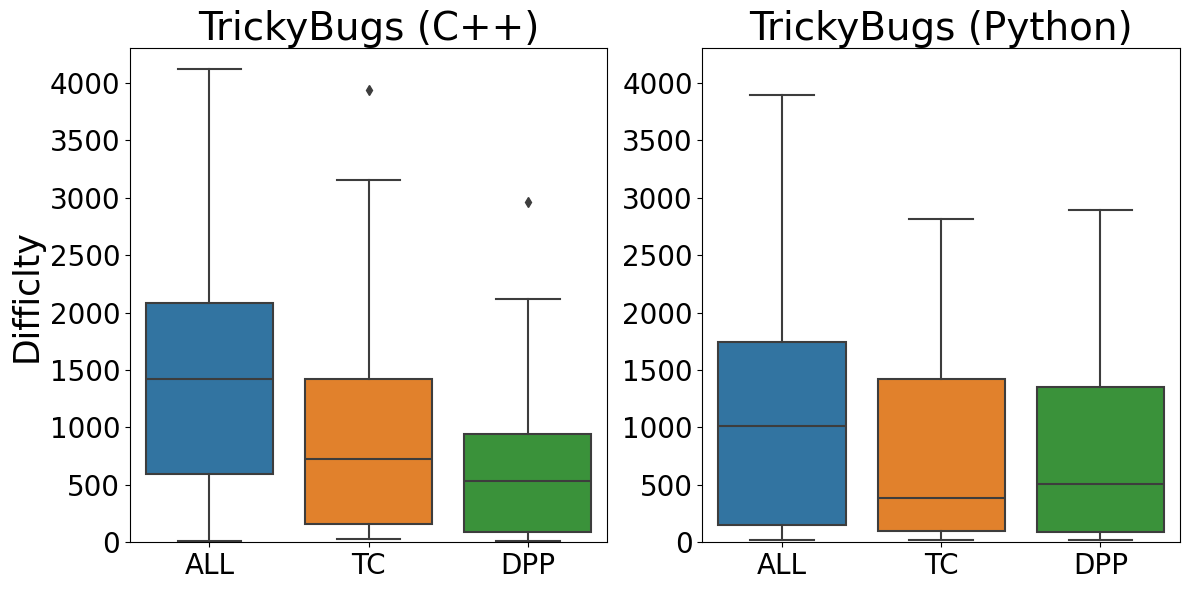

In [21]:
dfp_cpp_res=dpp_results[10] # the k with best F1 score is 10
tc_cpp_res=tc_results[10] # the k with best F1 score is 10
dfp_py_res=dpp_results_py[2] # the k with best F1 score is 2
tc_py_res=tc_results_py[10]# the k with best F1 score is 10
 
threhold=0.5
dfp_cpp_pid=filter_by_precision(dfp_cpp_res,threhold)
tc_cpp_pid=filter_by_precision(tc_cpp_res,threhold)
dfp_py_pid=filter_by_precision(dfp_py_res,threhold)
tc_py_pid=filter_by_precision(tc_py_res,threhold)
dfp_cpp_diff=list(dfp_cpp_pid.apply(pid2diff))
tc_cpp_diff=list(tc_cpp_pid.apply(pid2diff))
dfp_py_diff=list(dfp_py_pid.apply(pid2diff))
tc_py_diff=list(tc_py_pid.apply(pid2diff))
cpp_pid=list(set(df_chat['pid']))
python_pid=list(set(df_chat_py['pid']))
cpp_diff=list(map(pid2diff,cpp_pid))
python_diff=list(map(pid2diff,python_pid))

data_cpp = {
    'Difficulty': cpp_diff + tc_cpp_diff + dfp_cpp_diff,
    'Group': ['ALL'] * len(cpp_diff) + ['TC'] * len(tc_cpp_diff) + ['DPP'] * len(dfp_cpp_diff)
}

data_python = {
    'Difficulty': python_diff + tc_py_diff + dfp_py_diff,
    'Group': ['ALL'] * len(python_diff) + ['TC'] * len(tc_py_diff) + ['DPP'] * len(dfp_py_diff)
}

df_cpp = pd.DataFrame(data_cpp)
df_python = pd.DataFrame(data_python)


plt.figure(figsize=(12, 6))
y_ticks=[0,500,1000,1500,2000,2500,3000,3500,4000]
plt.subplot(1, 2, 1)  
sns.boxplot(x='Group', y='Difficulty', data=df_cpp)
plt.title('TrickyBugs (C++)',fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.yticks(y_ticks)
plt.ylim(0,4300)
plt.xlabel("")
plt.ylabel('Difficlty', fontsize=25)

plt.subplot(1, 2, 2) 
sns.boxplot(x='Group', y='Difficulty', data=df_python)
plt.title('TrickyBugs (Python)',fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.yticks(y_ticks)
plt.ylim(0,4300)
plt.xlabel("")
plt.ylabel('', fontsize=18)
plt.tight_layout()
plt.show()


3. Load the problem-level passing results of the program variants generated by `TC` and `DPP`.

In [22]:
tc_suball=pd.read_pickle("../Data/tc_suball.pkl")
dfp_suball=pd.read_pickle("../Data/dfp_suball.pkl")

def get_avg(df):
    df_avg = df.groupby(['pid', 'diff']).agg(
    avg_submit=pd.NamedAgg(column='submit_bool', aggfunc='mean'),
    avg_extra=pd.NamedAgg(column='extra_bool', aggfunc='mean')
    ).reset_index()
    return df_avg
tc_avg=get_avg(tc_suball)
dfp_avg=get_avg(dfp_suball)

4. Then we plot the Figure 8 with the following code.

/storage1/user/liukaibo/miniconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/storage1/user/liukaibo/miniconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/storage1/user/liukaibo/miniconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

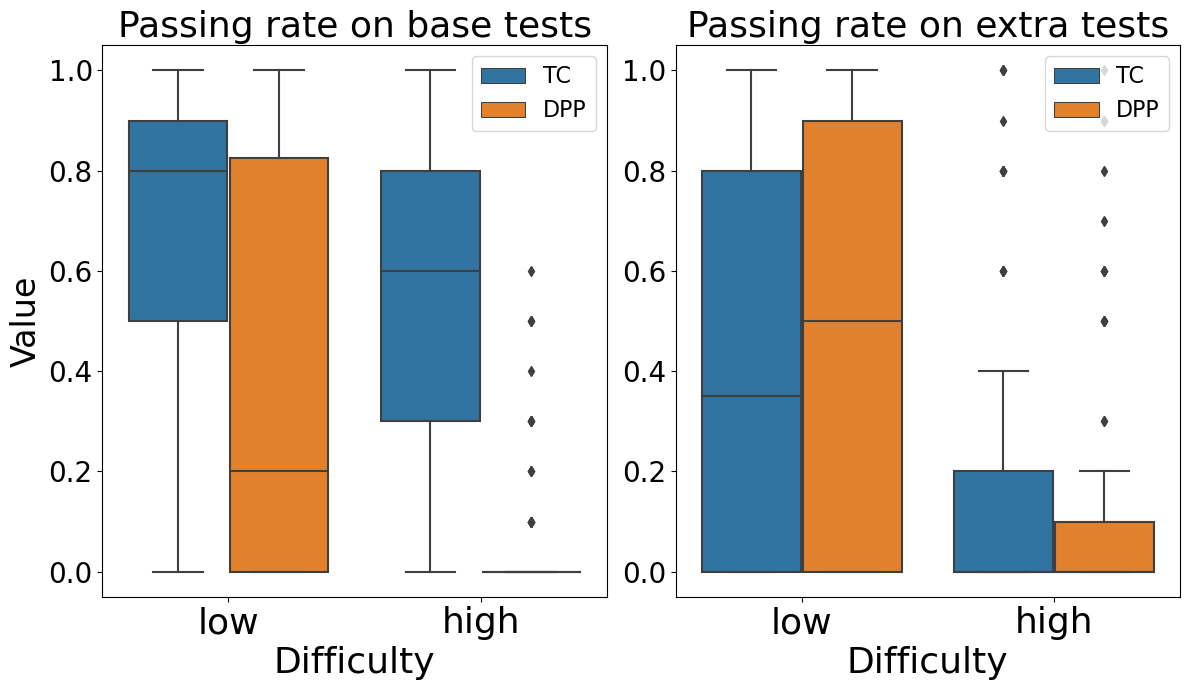

In [23]:
n_groups = 2  
tc_avg['Group'] = pd.qcut(tc_avg['diff'], q=n_groups,labels=['low','high'])
dfp_avg['Group'] = pd.qcut(dfp_avg['diff'], q=n_groups,labels=['low','high'])


tc_avg['Method'] = 'TC'
dfp_avg['Method'] = 'DPP'
combined = pd.concat([tc_avg, dfp_avg])


plt.figure(figsize=(12, 7))

# base tests
plt.subplot(1, 2, 1)
sns.boxplot(data=combined, x='Group', y='avg_submit', hue='Method')
plt.title('Passing rate on base tests',fontsize=26)
plt.xlabel('Difficulty',fontsize=26)
plt.ylabel('Value',fontsize=24)
plt.legend(fontsize=16,loc='upper right')
plt.tick_params(axis='x', labelsize=26) 
plt.tick_params(axis='y', labelsize=20)  

# extra tests
plt.subplot(1, 2, 2)
sns.boxplot(data=combined, x='Group', y='avg_extra', hue='Method')
plt.title('Passing rate on extra tests',fontsize=26)
plt.xlabel('Difficulty',fontsize=26)
plt.ylabel('',fontsize=22)
plt.legend(fontsize=16,loc='upper right')
plt.tick_params(axis='x', labelsize=26) 
plt.tick_params(axis='y', labelsize=20) 


plt.tight_layout()
plt.show()